<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Astrophysics</a> .
</div>

<a id="data-desc"></a>

<h1> Modelling Customer Churn using Xgboost</h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

References
- [Github: xgboost](https://github.com/dmlc/xgboost)
- [Kaggle: Predicting Customer Churn](https://www.kaggle.com/raywilliam/customer-churn-prediction-xgboost-hyperbandcv)
- [Kaggle: Hyper-Parameter Optimization - XGBoost](https://www.kaggle.com/vibhaas/hyper-parameter-optimization-xgboost)

<a id="lib"></a>

<h1> Load the libraries </h1>

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [1]:
import time

time_start_notebook = time.time()

## Colab

In [2]:
%%capture
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # usual imports
    !pip install watermark
    !pip install scikit-plot

    # HPO
    !git clone https://github.com/thuijskens/scikit-hyperband.git
    sys.path.append('scikit-hyperband/hyperband')

    # update modules
    !pip uninstall xgboost
    !pip install -U xgboost

    print('Environment: Google Colab')

In [3]:
sys.path.append('/Users/poudel/Dropbox/a00_Resources/hyperband/')
from hyperband_search import HyperbandSearchCV

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import os,sys,time
import matplotlib.pyplot as plt
sns.set()
import joblib
from tqdm import tqdm_notebook as tqdm

import plotly_express as px

from sklearn.preprocessing import OneHotEncoder
import imblearn
from imblearn.over_sampling import SMOTE
import sklearn.metrics as skmetrics

# warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.optimize.linesearch import LineSearchWarning

warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter('ignore', category=LineSearchWarning)

SEED = 100
pd.set_option('max_columns',100)
pd.set_option('max_colwidth',200)
pd.set_option('plotting.backend','matplotlib') # matplotlib, bokeh, altair, plotly

%load_ext watermark
%watermark -iv

autopep8       1.5.2
numpy          1.19.4
imblearn       0.7.0
json           2.0.9
seaborn        0.11.0
joblib         0.17.0
pandas         1.1.4
plotly_express 0.4.1



<a id="useful" ></a>

<h1> Useful Scripts </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [5]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

<a id="load-data" ></a>

<h1> Load the Data </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [6]:
path_data_train = '../data/raw/train.csv'
path_data_test = '../data/raw/test.csv'

if ENV_COLAB:
    path_data_train = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/raw/train.csv'
    path_data_test = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/Telco_Customer_Churn/raw/test.csv'

In [7]:
df_train = pd.read_csv(path_data_train)
df_test = pd.read_csv(path_data_test)

print(df_train.shape)
print(df_test.shape)
df_train.head(2).append(df_train.tail(2))

(5634, 21)
(1409, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1621-YNCJH,Female,0,Yes,No,36,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,Yes,Two year,Yes,Credit card (automatic),106.05,3834.4,No
1,7143-BQIBA,Male,0,No,No,10,Yes,No,DSL,Yes,No,No,Yes,Yes,No,Month-to-month,No,Bank transfer (automatic),62.25,612.95,No
5632,0862-PRCBS,Female,0,Yes,Yes,68,Yes,Yes,Fiber optic,No,Yes,No,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),103.75,7039.45,No
5633,4656-CAURT,Male,0,No,No,69,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),23.95,1713.1,No


In [8]:
target_name = 'Churn'

<a id="eda" ></a>

<h1> Data Processing  </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [9]:
sys.path.append('../src')
from util import clean_data

In [10]:
index_name = 'customerID'

df_train = clean_data(df_train)
df_test  = clean_data(df_test)


ser_ytrain = df_train.pop(target_name).map({'No':0,'Yes':1})
ser_ytest = df_test.pop(target_name).map({'No':0,'Yes':1})

ser_train_ids = df_train.pop(index_name)
ser_ytest_ids = df_test.pop(index_name)

ytrain_full = np.array(ser_ytrain).ravel()
ytest = np.array(ser_ytest).ravel()

df_Xtest = df_test

In [11]:
df_train.head()

,tenure,MonthlyCharges,TotalCharges,Contract_TotalCharges_mean,Contract_TotalCharges_mean_diff,PaymentMethod_MonthlyCharges_mean,PaymentMethod_MonthlyCharges_mean_diff,MultipleLines_Ordinal,SeniorCitizen_Not_SenCit,SeniorCitizen_SeniorCitizen,Partner_No_Partner,Partner_Partner,Dependents_Dependents,Dependents_No_Dependents,PaperlessBilling_No_PaperlessBill,PaperlessBilling_PaperlessBill,PhoneService_No_PhoneService,PhoneService_PhoneService,OnlineSecurity_No internet service,OnlineSecurity_No_OnlineSecurity,OnlineSecurity_OnlineSecurity,OnlineBackup_No internet service,OnlineBackup_No_OnlineBackup,OnlineBackup_OnlineBackup,DeviceProtection_DeviceProtection,DeviceProtection_No internet service,DeviceProtection_No_DeviceProtection,TechSupport_No internet service,TechSupport_No_TechSupport,TechSupport_TechSupport,StreamingTV_No internet service,StreamingTV_No_StreamingTV,StreamingTV_StreamingTV,StreamingMovies_No internet service,StreamingMovies_No_StreamingMov,StreamingMovies_StreamingMov,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Dependents_No_Partner_Dependents,Partner_Dependents_No_Partner_No_Dependents,Partner_Dependents_Partner_Dependents,Partner_Dependents_Partner_No_Dependents,SeniorCitizen_Dependents_Not_SenCit_Dependents,SeniorCitizen_Dependents_Not_SenCit_No_Dependents,SeniorCitizen_Dependents_SeniorCitizen_Dependents,SeniorCitizen_Dependents_SeniorCitizen_No_Dependents,SeniorCitizen_Partner_Not_SenCit_No_Partner,SeniorCitizen_Partner_Not_SenCit_Partner,SeniorCitizen_Partner_SeniorCitizen_No_Partner,SeniorCitizen_Partner_SeniorCitizen_Partner,SeniorCitizen_Contract_Not_SenCit_Month-to-month,SeniorCitizen_Contract_Not_SenCit_One year,SeniorCitizen_Contract_Not_SenCit_Two year,SeniorCitizen_Contract_SeniorCitizen_Month-to-month,SeniorCitizen_Contract_SeniorCitizen_One year,SeniorCitizen_Contract_SeniorCitizen_Two year,SeniorCitizen_TechSupport_Not_SenCit_No internet service,SeniorCitizen_TechSupport_Not_SenCit_No_TechSupport,SeniorCitizen_TechSupport_Not_SenCit_TechSupport,SeniorCitizen_TechSupport_SeniorCitizen_No internet service,SeniorCitizen_TechSupport_SeniorCitizen_No_TechSupport,SeniorCitizen_TechSupport_SeniorCitizen_TechSupport,SeniorCitizen_PaymentMethod_Not_SenCit_Bank transfer (automatic),SeniorCitizen_PaymentMethod_Not_SenCit_Credit card (automatic),SeniorCitizen_PaymentMethod_Not_SenCit_Electronic check,SeniorCitizen_PaymentMethod_Not_SenCit_Mailed check,SeniorCitizen_PaymentMethod_SeniorCitizen_Bank transfer (automatic),SeniorCitizen_PaymentMethod_SeniorCitizen_Credit card (automatic),SeniorCitizen_PaymentMethod_SeniorCitizen_Electronic check,SeniorCitizen_PaymentMethod_SeniorCitizen_Mailed check
0,36,106.05,3834.40,3683.643192,150.756808,65.801934,40.248066,2,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,10,62.25,612.95,1370.923131,-757.973131,67.564819,-5.314819,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,25,19.15,477.60,1370.923131,-893.323131,43.792328,-24.642328,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,7,20.00,137.60,1370.923131,-1233.323131,67.564819,-47.564819,1,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,24,20.30,459.95,1370.923131,-910.973131,43.792328,-23.492328,1,0,1,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [12]:
print(df_train.sum().sum(), df_test.sum().sum(),
      df_train.isna().sum().sum(), df_test.isna().sum().sum())

df_train.head()

26621171.299999997 6767495.3 0 0


,tenure,MonthlyCharges,TotalCharges,Contract_TotalCharges_mean,Contract_TotalCharges_mean_diff,PaymentMethod_MonthlyCharges_mean,PaymentMethod_MonthlyCharges_mean_diff,MultipleLines_Ordinal,SeniorCitizen_Not_SenCit,SeniorCitizen_SeniorCitizen,Partner_No_Partner,Partner_Partner,Dependents_Dependents,Dependents_No_Dependents,PaperlessBilling_No_PaperlessBill,PaperlessBilling_PaperlessBill,PhoneService_No_PhoneService,PhoneService_PhoneService,OnlineSecurity_No internet service,OnlineSecurity_No_OnlineSecurity,OnlineSecurity_OnlineSecurity,OnlineBackup_No internet service,OnlineBackup_No_OnlineBackup,OnlineBackup_OnlineBackup,DeviceProtection_DeviceProtection,DeviceProtection_No internet service,DeviceProtection_No_DeviceProtection,TechSupport_No internet service,TechSupport_No_TechSupport,TechSupport_TechSupport,StreamingTV_No internet service,StreamingTV_No_StreamingTV,StreamingTV_StreamingTV,StreamingMovies_No internet service,StreamingMovies_No_StreamingMov,StreamingMovies_StreamingMov,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Dependents_No_Partner_Dependents,Partner_Dependents_No_Partner_No_Dependents,Partner_Dependents_Partner_Dependents,Partner_Dependents_Partner_No_Dependents,SeniorCitizen_Dependents_Not_SenCit_Dependents,SeniorCitizen_Dependents_Not_SenCit_No_Dependents,SeniorCitizen_Dependents_SeniorCitizen_Dependents,SeniorCitizen_Dependents_SeniorCitizen_No_Dependents,SeniorCitizen_Partner_Not_SenCit_No_Partner,SeniorCitizen_Partner_Not_SenCit_Partner,SeniorCitizen_Partner_SeniorCitizen_No_Partner,SeniorCitizen_Partner_SeniorCitizen_Partner,SeniorCitizen_Contract_Not_SenCit_Month-to-month,SeniorCitizen_Contract_Not_SenCit_One year,SeniorCitizen_Contract_Not_SenCit_Two year,SeniorCitizen_Contract_SeniorCitizen_Month-to-month,SeniorCitizen_Contract_SeniorCitizen_One year,SeniorCitizen_Contract_SeniorCitizen_Two year,SeniorCitizen_TechSupport_Not_SenCit_No internet service,SeniorCitizen_TechSupport_Not_SenCit_No_TechSupport,SeniorCitizen_TechSupport_Not_SenCit_TechSupport,SeniorCitizen_TechSupport_SeniorCitizen_No internet service,SeniorCitizen_TechSupport_SeniorCitizen_No_TechSupport,SeniorCitizen_TechSupport_SeniorCitizen_TechSupport,SeniorCitizen_PaymentMethod_Not_SenCit_Bank transfer (automatic),SeniorCitizen_PaymentMethod_Not_SenCit_Credit card (automatic),SeniorCitizen_PaymentMethod_Not_SenCit_Electronic check,SeniorCitizen_PaymentMethod_Not_SenCit_Mailed check,SeniorCitizen_PaymentMethod_SeniorCitizen_Bank transfer (automatic),SeniorCitizen_PaymentMethod_SeniorCitizen_Credit card (automatic),SeniorCitizen_PaymentMethod_SeniorCitizen_Electronic check,SeniorCitizen_PaymentMethod_SeniorCitizen_Mailed check
0,36,106.05,3834.40,3683.643192,150.756808,65.801934,40.248066,2,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,10,62.25,612.95,1370.923131,-757.973131,67.564819,-5.314819,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,25,19.15,477.60,1370.923131,-893.323131,43.792328,-24.642328,1,1,0,0,1,1,0,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,7,20.00,137.60,1370.923131,-1233.323131,67.564819,-47.564819,1,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,24,20.30,459.95,1370.923131,-910.973131,43.792328,-23.492328,1,0,1,1,0,0,1,0,1,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [13]:
ser_ytrain.head(2)

0    0
1    0
Name: Churn, dtype: int64

<a id="" ></a>

<h1>  Train Validation Split</h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [14]:
from sklearn.model_selection import train_test_split

df_Xtrain_full = df_train.copy()
ser_ytrain_full = ser_ytrain.copy()

df_Xtrain, df_Xvalid, ser_ytrain, ser_yvalid = train_test_split(
    df_Xtrain_full, ser_ytrain_full,
    test_size=0.2, random_state=SEED, stratify=ser_ytrain_full)

ytrain = ser_ytrain.to_numpy().ravel()
yvalid = ser_yvalid.to_numpy().ravel()

<a id="" ></a>

<h1>  Modelling </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [15]:
import xgboost as xgb

In [16]:
model = xgb.XGBClassifier(objective='binary:logistic',
                          missing=None,
                          seed=SEED)

model.fit(df_Xtrain, ser_ytrain,
          verbose=False,
          early_stopping_rounds=10,
          eval_metric='aucpr',
          eval_set = [(df_Xvalid,ser_yvalid)])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=100,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [17]:
ypreds = model.predict(df_Xtest)
ypreds[:5]

array([0, 0, 0, 0, 0])

In [18]:
yprobs2d = model.predict_proba(df_Xtest)
yprobs2d[:5]

array([[0.7018988 , 0.29810122],
       [0.86226153, 0.13773844],
       [0.54212254, 0.45787746],
       [0.91786695, 0.08213308],
       [0.91786695, 0.08213308]], dtype=float32)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409

[[923 112]
 [186 188]]


,Accuracy,Precision,Recall,F1-score,AUC
xgboost,0.7885,0.6267,0.5027,0.5579,0.6972


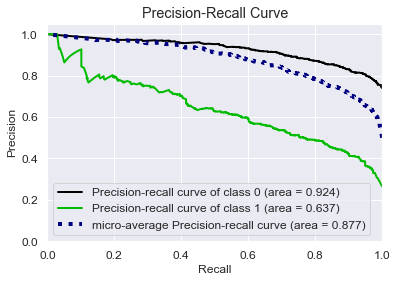

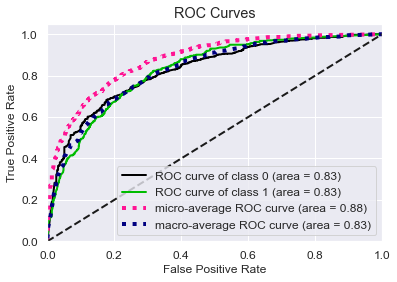

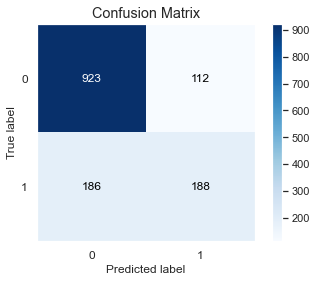

In [19]:
def model_eval_bin(model_name,ytest,ypreds,yprobs2d,show_plots=True):
    import sklearn.metrics as skmetrics
    import scikitplot.metrics as skpmetrics
    import os

    acc       = skmetrics.accuracy_score(ytest,ypreds)
    precision = skmetrics.precision_score(ytest,ypreds)
    recall    = skmetrics.recall_score(ytest,ypreds)
    f1        = skmetrics.f1_score(ytest,ypreds)
    auc       = skmetrics.roc_auc_score(ytest,ypreds)

    print(skmetrics.classification_report(ytest,ypreds))
    print(skmetrics.confusion_matrix(ytest,ypreds))

    df_res = pd.DataFrame({'Accuracy':[acc],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1-score': [f1],
                          'AUC': [auc]},index=[model_name])

    display(df_res.style.format("{:.4f}"))
    if not os.path.isdir('../outputs'):
        os.makedirs('../outputs')
    o = '.' if ENV_COLAB else '../outputs/'
    df_res.to_csv(o+f'model_{model_name}.csv',index=True)

    skpmetrics.plot_precision_recall(ytest,yprobs2d) # more focus on minority
    skpmetrics.plot_roc_curve(ytest,yprobs2d) # equal focus on both groups
    skpmetrics.plot_confusion_matrix(ytest,ypreds)

model_eval_bin('xgboost',ytest,ypreds,yprobs2d,show_plots=True)

<a id="" ></a>

<h2>  Cross Validation </h2> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
params = {
    'max_depth' : [3,4,5],
    'learning_rate':[0.01,0.05,0.1,0.5],
    'gamma':[0,0.5,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[2,3]
    
}

params_fixed = dict(objective = 'binary:logistic',missing = None,
                    subsample = 0.8,colsample_bytree=0.6)
model = xgb.XGBClassifier(**params_fixed)
grid = GridSearchCV(model,params,scoring='roc_auc',n_jobs=-1,cv=5)

In [22]:
# grid.fit(df_Xtrain,ser_ytrain,
#          early_stopping_rounds = 10,
#          eval_metric           = 'auc',
#          eval_set              = [(df_Xvalid, ser_yvalid)],
#          verbose=False
#         )
# print(grid.best_params_)

In [23]:
params_best = {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4,
               'reg_lambda': 10.0, 'scale_pos_weight': 2}

In [24]:
params = params_fixed
params.update(params_best)

model = xgb.XGBClassifier(**params)
model

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=0, gpu_id=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.05, max_delta_step=None, max_depth=4,
              min_child_weight=None, missing=None, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=10.0,
              scale_pos_weight=2, subsample=0.8, tree_method=None,
              validate_parameters=None, verbosity=None)

              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.54      0.71      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.79      0.76      0.77      1409

[[812 223]
 [109 265]]


,Accuracy,Precision,Recall,F1-score,AUC
xgboost_1,0.7644,0.5430,0.7086,0.6148,0.7465


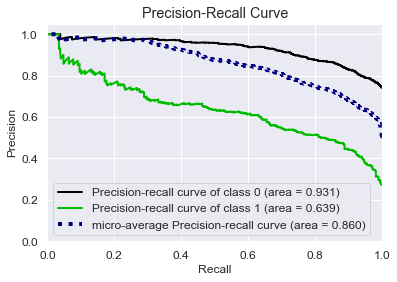

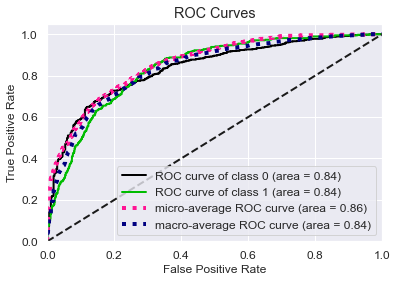

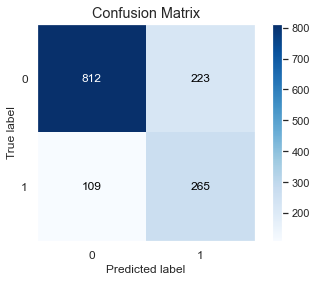

In [25]:
model.fit(df_Xtrain_full,ser_ytrain_full)
ypreds = model.predict(df_Xtest)
yprobs2d = model.predict_proba(df_Xtest)

model_eval_bin('xgboost_1',ytest,ypreds,yprobs2d,show_plots=False)

# Hyperband SearchCV

In [26]:
# help(HyperbandSearchCV)

In [27]:
%%time

from sklearn import metrics as skmetrics

import scipy.stats as stats
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy.optimize.linesearch import LineSearchWarning

warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter('ignore', category=LineSearchWarning)

# Define our model
params_fixed = {'objective'   : 'binary:logistic', 
                'random_state': SEED,
                'n_jobs'      : 1
               }

params_hyp = {
    'max_depth'        : stats.randint(3,6),
    'learning_rate'    : stats.loguniform(0.01, 1.0),
    'n_estimators'     : stats.randint(100, 1000),
    'subsample'        : [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha'        : stats.loguniform(0.01, 1.0),
    'reg_lambda'       : stats.loguniform(0.01, 1.0),
    'scale_pos_weight' : [2,3,4]
    }

model = xgb.XGBClassifier(**params_fixed)


def custom_loss(y_true, y_pred):
    tn, fp, fn, tp = skmetrics.confusion_matrix(y_true,y_pred).ravel()
    loss = 400*tp - 200*fn - 100*fp
    return loss

scoring = skmetrics.make_scorer(custom_loss, greater_is_better=True)

# Perform Hyperparameter Tuning
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=SEED)
grid = HyperbandSearchCV(model,params_hyp, 
                              resource_param = 'n_estimators',
                              min_iter       = 100,
                              max_iter       = 1000, # use 1k or 2k
                              cv             = cv, 
                              scoring        = scoring,# 'roc_auc',
                              refit          = True,
                              verbose        = 0,
                              random_state   = SEED
                          )


# grid.fit(df_Xtrain_full, ser_ytrain_full)
# print('Best parameters:  ', grid.best_params_)

# params_best = grid.best_params_
# params = params_fixed
# params.update(params_best)

# Wall time: 42min 8s

Best parameters:   {'learning_rate': 0.026305899424768367, 'max_depth': 4, 'n_estimators': 111, 'reg_alpha': 0.4701794309476201, 'reg_lambda': 0.014151087504351043, 'scale_pos_weight': 4, 'subsample': 0.9}
CPU times: user 41min, sys: 9.92 s, total: 41min 10s
Wall time: 42min 8s


In [28]:
# params_best = {'learning_rate': 0.010265426899287895, 'max_depth': 4,
#                'n_estimators': 500, 'reg_alpha': 0.390233920364201,
#                'reg_lambda': 0.010727782071330185,
#                'scale_pos_weight': 3, 'subsample': 0.9}

params_best = {'learning_rate': 0.026305899424768367, 'max_depth': 4,
               'n_estimators': 111, 'reg_alpha': 0.4701794309476201,
               'reg_lambda': 0.014151087504351043, 'scale_pos_weight': 4,
               'subsample': 0.9}

model = xgb.XGBClassifier(**params_best,random_state=SEED)

model.fit(df_Xtrain_full,ser_ytrain_full)
ypreds = model.predict(df_Xtest)
yprobs2d = model.predict_proba(df_Xtest)
print(skmetrics.confusion_matrix(ytest,ypreds))

[[669 366]
 [ 43 331]]


<a id="" ></a>

<h1>  Model Evaluation </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

Profit = $87,200
              precision    recall  f1-score   support

           0       0.94      0.65      0.77      1035
           1       0.47      0.89      0.62       374

    accuracy                           0.71      1409
   macro avg       0.71      0.77      0.69      1409
weighted avg       0.82      0.71      0.73      1409

[[669 366]
 [ 43 331]]


,Accuracy,Precision,Recall,F1-score,AUC
xgboost,0.7097,0.4749,0.8850,0.6181,0.7657


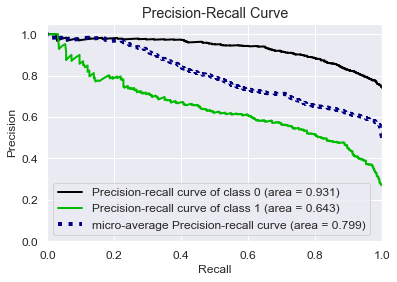

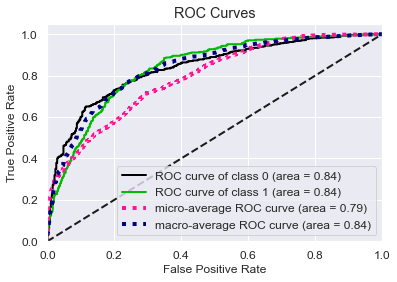

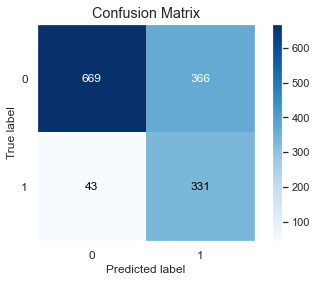

In [32]:
profit = custom_loss(ytest,ypreds)
print(f'Profit = ${profit:,.0f}')
model_eval_bin('xgboost',ytest,ypreds,yprobs2d,show_plots=True)

<a id="" ></a>

<h1>  Time Taken </h1> 

<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover" title="go to TOC">Go to Top</a>

In [30]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 42 min 17 secs
